In [ ]:
from random import Random
import numpy as np
from matplotlib.pyplot import figure
from math import sqrt
from time import monotonic #time and increasing
SEED = 5

In [ ]:
def gen_rand_pts(N=1000):
    """
    returns 2 lists where the first one contains the x-coordinates of the points generated randomly,
    and the second one contains the y-coordinates of the points generated randomly
    :param N: (int, optional) default = 1000,
        number of random generated points
    :return: tuple of 2 lists
    """
    if N<=0:
        raise ValueError("Wrong value for N")
    rand_gen = Random(x=SEED)
    return (
        [rand_gen.uniform(a=0, b=1) for _ in range(N)],
        [rand_gen.uniform(a=0, b=1) for _ in range(N)]
    )

In [ ]:
def loss( x_p, y_p, batch_x, batch_y):
    """
takes the data set and the initial guess and returns the evaluation of our loss function
:param data_x:(list of floats) : x-coordinate of the data point for the training data
:param data_y:(list of floats) : y-coordinate of the data point for the training data
:param x_p:(float) : x-coordinate of the data point for the initial guess
:param y_p:(float) : y-coordinate of the data point for the initial guess
:return: loss (float): The root mean squared distance between
    the point (x_p, y_p) and the data points
"""
    n_inv = 1/len(batch_x)
    return n_inv * sum(
        [ ((x_i-x_p)**2 + (y_i-y_p)**2)**0.5 for x_i, y_i in zip(batch_x, batch_y)]
    )

In [ ]:
def cal_grad(x_p, y_p):
    sum_x , sum_y = 0, 0
    c = -1/len(data_x)
    for x_i, y_i in zip(data_x, data_y):
        inv_sqrt = ( (x_i-x_p) ** 2 + (y_i-y_p) ** 2 ) ** (-0.5)
        sum_x += inv_sqrt*(x_i -x_p)
        sum_y += inv_sqrt*(y_i - y_p)
    return c*sum_x, c*sum_y

In [ ]:
data_x, data_y = gen_rand_pts()
x_p, y_p = 0.3, 0.3
grad_x, grad_y = cal_grad(x_p, y_p)
cur_loss = loss(x_p, y_p, data_x, data_y)
print(f"closed form: gradient for x_p {grad_x}, gradient for y_p {grad_y} ")
print(f"closed form loss = {cur_loss}")

## Pytorch as an example of Autograd engines

In [ ]:
import torch
pnt = torch.tensor([0.3, 0.3])
pnt.requires_grad = True
pnt.retain_grad()#In PyTorch, the retain_grad() method is used to retain the gradients of a tensor, which means that the gradients will not be automatically cleared during the backward pass. This method is useful when you want to compute multiple gradients for a tensor or when you want to access the gradients of an intermediate computation.
data = torch.tensor([data_x, data_y])
data = data.t()
print(data.shape, pnt.shape)

loss_torch = torch.mean(torch.sqrt(((data - pnt)**2).sum(dim = 1)))
print(f"loss : {loss_torch}")
loss_torch.backward()
print(f"torch gradient : {pnt.grad.data}")

## Building Autograd from scratch

In [ ]:
class comp_node:
    """
A computational node that represents a mathematical operation.

Attributes:
-----------
val : float
    The numerical value of the computational node.
children : list, optional
    A list of child nodes. Default is an empty list.
grad : float
    The gradient of the computational node with respect to a target variable.
op : str
    The type of operation performed by the node.
backward : function
    The function to compute the gradients of this node.

Methods:
--------
__init__(self, val, children=[], op="assign"):
    Initializes a computational node object.

__to_comp_node(self, obj):
    Converts a non-comp_node object to a comp_node object.

__sub__(self, other):
    Subtracts another computational node from this node.

__rsub__(self, other):
    Subtracts this node from another computational node.

__pow__(self, exponent):
    Raises this node to a power.

__eq__(self, other):
    Checks if this node is equal to another node.

__add__(self, other):
    Adds another computational node to this node.

__radd__(self, other):
    Adds this node to another computational node.

__mul__(self, other):
    Multiplies this node by another computational node.

__rmul__(self, other):
    Multiplies another computational node by this node.

__repr__(self):
    Returns a string representation of the computational node.
"""
    def __init__(self, val, children=[], op="assign"):
        """
        Initializes a computational node object.

        Parameters:
        -----------
        val : float
            The numerical value of the computational node.
        children : list, optional
             A list of child nodes. Default is an empty list.
        op : str, optional
            The type of operation performed by the node. Default is "assign".
        """
        self.val = val
        self.children = children
        self.grad = 0
        self.op = op
        self.backward = lambda : None

    def __to_comp_node(self, obj):
        """
        Converts a non-comp_node object to a comp_node object.

        Parameters:
        -----------
        obj : any
            The object to be converted.

        Returns:
        --------
        comp_node
            The converted object as a computational node.
        """
        if not isinstance(obj, comp_node):
            return comp_node(val = obj)
        return obj

    def __sub__(self, other):
        """
    Subtracts another computational node from this node.

    Parameters:
    -----------
    other : comp_node or float
        The node or value to be subtracted.

    Returns:
    --------
    comp_node
        A new computational node representing the subtraction operation.
    """
        """This defines the behavior of the - operator for comp_node objects, which represents subtraction. It creates a new comp_node object (out) with the appropriate values and sets its backward propagation function (_backward_prop) to compute the gradients of the current node and its dependency (other) with respect to the output node (out). It then returns the out node."""
        other = self.__to_comp_node(other)
        out = comp_node(val=self.val-other.val, children=[self, other],
                        op = "sub")
        #return self.val - other.val
        def _backward_prop():
            """The += operator is used to accumulate gradients during backpropagation.
            In automatic differentiation (autodiff), the gradients are computed using the chain rule of differentiation. Each node in a computation graph (represented by comp_node in this code) stores its gradient with respect to the output of the overall computation. During backpropagation, the gradient of the loss with respect to each intermediate node in the graph is computed and added to the node's gradient."""
            self.grad += out.grad * 1
            other.grad += out.grad * (-1)
        out.backward = _backward_prop
        return out
    def __rsub__(self, other):
        """This defines the behavior of the - operator when the comp_node object is on the right-hand side of the operator. It simply calls the regular subtraction method with the order of the operands reversed."""
        other = self.__to_comp_node(other)
        return other - self

    def __pow__(self, exponent):
        """This defines the behavior of the ** operator for comp_node objects, which represents exponentiation. It creates a new comp_node object (out) with the appropriate values and sets its backward propagation function (_backward_prop) to compute the gradient of the current node with respect to its dependency (self) and the output node (out). It then returns the out node."""
        if not isinstance(exponent, (int, float)):
            raise ValueError(" Unsupported Type")
        out = comp_node(val = self.val**exponent, children=[self],
                        op=f"power {exponent}")

        def _backward_prop():
            self.grad += out.grad * (exponent * self.val**(exponent - 1))
        out.backward = _backward_prop # use no parentheses
        return out

    def __eq__(self, other):
        """This defines the behavior of the == operator for comp_node objects, which simply checks if the values of the two nodes are equal."""
        return  self.val == other.val

    def __add__(self, other):
        other = self.__to_comp_node(other)
        out = comp_node(val=self.val+other.val, children=[self, other],
                        op = "add")
        def _backward_prop():
            self.grad += out.grad * 1
            other.grad += out.grad * 1
        out.backward = _backward_prop
        return out

    def __radd__(self, other):
        other = self.__to_comp_node(other)
        return other + self

    def __mul__(self, other):
        other = self.__to_comp_node(other)
        return comp_node(val = self.val * other.val , op = "mult",
                         children=[self, other])

    def __rmul__(self, other):
        other = self.__to_comp_node(other)
        return self * other

    def __repr__(self):
        return f"op : {self.op} | val : {self.val:0.4f} | " \
               f"children : {len(self.children)} | gradient : {self.grad}"

assert comp_node(val=5).val == 5 ," Assignment failed"
assert (comp_node(val=5) - comp_node(val=3)).val== 2
assert (comp_node(val=5) - 3).val == 2
assert (3 - comp_node(val=5)).val == -2
assert ((comp_node(val= 5))**2).val == 25
assert ((comp_node(val= 5))**2) == comp_node(val = 25)

assert (comp_node(val=5) + comp_node(val=3)).val== 8
assert (comp_node(val=5) + 3).val == 8
assert (3 + comp_node(val=5)).val == 8

assert (comp_node(val=5) * comp_node(val=3)).val== 15
assert (3 * comp_node(val=5)).val == 15

In [ ]:
data_x, data_y = gen_rand_pts(1)
print(f"data_x : {data_x}, data_y : {data_y}")
x_p, y_p = comp_node(val = 0.3), comp_node(val=0.3)
def loss_graph(x_p, y_p, data_x, data_y):
    I_x, I_y = x_p - data_x, y_p - data_y
    g_x, g_y = I_x ** 2, I_y ** 2
    M = g_x + g_y
    L = M ** 0.5
    return L , [L, M, g_x, g_y , I_x, I_y, x_p, y_p]
l , rev_topo_sort = loss_graph(x_p, y_p, data_x[0], data_y[0])
rev_topo_sort[0].grad = 1
#print(l)
for i, node in enumerate(rev_topo_sort):
    node.backward()
    print(i, node)


## Lecture 9

### Adjacency Matrix

An adjacency matrix is a square matrix that represents the connections between vertices in a graph. In an adjacency matrix, the rows and columns represent the vertices of the graph, and the entry in row i and column j indicates whether there is an edge from vertex i to vertex j.

Typically, an entry of 1 indicates the presence of an edge, and an entry of 0 indicates the absence of an edge. In the case of weighted graphs, the entry can represent the weight of the edge.

The adjacency matrix is a useful tool for analyzing graphs, as it allows for efficient computation of graph properties such as degree, clustering coefficient, and shortest paths. It is also used in algorithms for graph traversal and search, such as Dijkstra's algorithm and the Floyd-Warshall algorithm.

#### Time and space complexity

The time complexity of working with an adjacency matrix depends on the operation being performed. Here are some common time complexities for different operations on an n x n adjacency matrix:

Checking if there is an edge between two vertices: O(1)
This operation is constant time, as it simply involves looking up a single entry in the matrix.

Finding the degree of a vertex: O(n)
To find the degree of a vertex, we need to count the number of 1's in the row or column corresponding to that vertex. Since there are n entries in the row or column, this operation takes O(n) time.

Computing the transitive closure of the graph: O(n^3)
The transitive closure of a graph is a matrix that indicates whether there is a path between every pair of vertices. It can be computed using the Floyd-Warshall algorithm, which has a time complexity of O(n^3).

Determining if the graph is connected: O(n^2)
To determine if the graph is connected, we can perform a depth-first or breadth-first search from any vertex and check if all vertices are reachable. This operation requires visiting each vertex once, which takes O(n) time, and checking if there is an edge between two vertices, which takes O(1) time. Therefore, the total time complexity is O(n^2).

Finding the shortest path between two vertices: O(n^3)
The shortest path between two vertices can be computed using the Floyd-Warshall algorithm, which has a time complexity of O(n^3).

In general, working with an adjacency matrix takes O(n^2) space, as each entry in the matrix needs to be stored. The time complexity of other operations will depend on the specific algorithm being used.

#### The problem with adjacency matrix

While adjacency matrices are a useful tool for analyzing graphs, there are some potential problems associated with their use:

Space complexity: The space required for an adjacency matrix grows quadratically with the number of vertices in the graph. For large graphs, this can become a significant memory burden, especially if the graph is sparse (i.e., has few edges).

Limited scalability: Adjacency matrices can become computationally expensive to work with for very large graphs. Many graph algorithms have time complexity that grows polynomially or worse with the number of vertices or edges, which can make them impractical to use for graphs with millions or billions of vertices.

Inefficient for sparse graphs: If the graph is sparse (i.e., has few edges), then the majority of the entries in the adjacency matrix will be 0. This means that a lot of space is wasted storing information that is not necessary for analyzing the graph.

Updating the graph: If the graph is dynamic and edges are added or removed frequently, then updating the adjacency matrix can be computationally expensive. Adding or removing an edge requires updating several entries in the matrix, which can take O(n^2) time.

In contrast, adjacency lists can address some of these issues, as they use less memory and can be more efficient for sparse graphs or dynamic graphs. However, they can be less efficient for some graph algorithms, such as computing the transitive closure of the graph, which is more efficiently computed using an adjacency matrix.

#### Implementing adjacency matrix

In [ ]:
def adjacency_matrix(edges, num_vertices):
    """
    Takes in a list of edges and the number of vertices in the graph and returns an adjacency matrix as a 2D array.

    Parameters:
    - edges: a list of tuples representing edges in the graph, where each tuple contains two vertices (strings or integers)
    - num_vertices: an integer representing the number of vertices in the graph

    Returns:
    - a 2D array representing the adjacency matrix of the graph
    """
    adj_matrix = [[0 for _ in range(num_vertices)] for _ in range(num_vertices)]
    for edge in edges:
        v1, v2 = edge
        adj_matrix[v1][v2] = 1
        adj_matrix[v2][v1] = 1
    return adj_matrix


### Adjacency lists

An adjacency list is a way to represent a graph as a collection of linked lists, where each linked list corresponds to a vertex in the graph and contains the vertices that are adjacent to it.

In an adjacency list, each vertex in the graph is represented as a key in a dictionary, and the value associated with each key is a list of the vertices adjacent to that vertex. For an undirected graph, each edge should be added to the adjacency list of both vertices connected by the edge.

For example, consider the following undirected graph:
A -- B
|    |
C -- D
This graph can be represented using the following adjacency list:
{
  "A": ["B", "C"],
  "B": ["A", "D"],
  "C": ["A", "D"],
  "D": ["B", "C"]
}
In this adjacency list, the key "A" has a value of ["B", "C"], indicating that vertex "A" is adjacent to vertices "B" and "C". Similarly, the key "B" has a value of ["A", "D"], indicating that vertex "B" is adjacent to vertices "A" and "D".

Note that since the graph is undirected, each edge appears in the adjacency list of both vertices it connects.

Using an adjacency list can be useful for certain algorithms that require traversing the neighbors of each vertex in the graph. It is also more memory-efficient than an adjacency matrix for sparse graphs, where the number of edges is much smaller than the number of possible edges.

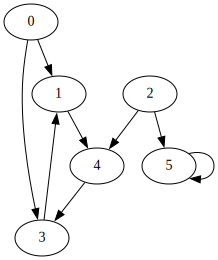

In [30]:
graph_1_vertices = set(range(8))
graph_1_edges = {
    0 : [1, 4],
    1 : [0, 5],
    2 : [5, 6],
    3 : [7],
    4 : [0],
    5 : [2, 6],
    6 : [2, 5, 7],
    7 : [3,6],
}

graph_2_vertices = set(range(6))
graph_2_edges = {
    0 : [1, 3],
    1 : [4],
    2 : [4, 5],
    3 : [1],
    4 : [3],
    5 : [5],
}

from graphviz import Digraph, Graph

def draw(vertices:set, edges:dict, directed:bool):
    """
    Takes in a set of vertices and a dictionary of edges and uses Graphviz to draw a visualization of the graph.

    Parameters:
    - vertices: a set of vertices in the graph
    - edges: a dictionary of edges in the graph, where each key is a vertex and the value is a list of adjacent vertices

    Returns:
    - a Graphviz Digraph object representing the visualization of the graph
    """
    global already_drawn
    if directed :
        dot = Digraph(format="svg")  # creates a new Digraph object with the SVG format
    else:
        dot = Graph(format='svg')
    for v in vertices:
        dot.node(name=str(v), label=f"{v}")  # adds a node to the graph for each vertex, with its label equal to its value
    if not directed:
        already_drawn = set()
    for k, v in edges.items():
        for curr_v in v:
            if directed:
                dot.edge(str(k), str(curr_v))  # adds an edge between each vertex and its adjacent vertices
            else:
                sorted_edge = tuple(sorted([k, curr_v]))
                if sorted_edge not in already_drawn:
                    already_drawn.add(sorted_edge)
                    dot.edge(str(k), str(curr_v))
    return dot  # returns the completed graph


graph_1 = draw(graph_2_vertices, graph_2_edges, True)
graph_1

## Graph Traversal

given a Graph G and a vertex to start at  S

# BFS

BFS stands for Breadth-First Search. It is a graph traversal algorithm that starts at a given source vertex and explores all the vertices at the same level (i.e., the same distance from the source) before moving on to the next level. The algorithm explores the graph in a breadth-first manner, hence the name.

Here's a step-by-step algorithm to perform BFS on a graph:

Initialize a queue and a set of visited vertices.
Add the source vertex to the queue and mark it as visited.
While the queue is not empty, dequeue the next vertex from the queue.
For each unvisited neighbor of the dequeued vertex, mark it as visited and enqueue it.
Repeat steps 3-4 until the queue is empty.

In [34]:
from collections import deque

#setting the graph
graph_vertices = graph_2_vertices
graph_edges = graph_2_edges

#setting the source vertex
s = 1

#creating q
q = deque()
visited = set()

#initializing
q.append(s)
visited.add(s)

while len(q) > 0:
    #pop the queue
    curr_vertex = q.popleft()

    #visit Nodes
    print(f" visiting node : {curr_vertex}")


    for neighbour  in graph_edges[curr_vertex]:
        if neighbour not in visited:
            q.append(neighbour)
            visited.add(neighbour)

 visiting node : 1
 visiting node : 4
 visiting node : 3


# DFS
DFS stands for Depth-First Search. It is a graph traversal algorithm that starts at a given source vertex and explores as far as possible along each branch before backtracking. The algorithm explores the graph in a depth-first manner, hence the name.

Here's a step-by-step algorithm to perform DFS on a graph:

Initialize a stack and a set of visited vertices.
Add the source vertex to the stack and mark it as visited.
While the stack is not empty, pop the next vertex from the stack.
For each unvisited neighbor of the popped vertex, mark it as visited and push it onto the stack.
Repeat steps 3-4 until the stack is empty.

In [35]:
s = 0
visited = set()
def dfs(v):
    if v in visited:
        return
    else:
        visited.add(v)
        print(f"visit before neighbours : {v}")
        for neighbour in graph_edges[v]:
            dfs(neighbour)
dfs(s)

visit before neighbours : 0
visit before neighbours : 1
visit before neighbours : 4
visit before neighbours : 3


In [39]:
visited = set()
def dfs(v):
    if v in visited:
        return
    else:
        visited.add(v)
        print(f"visit after neighbours : {v}")
    for neighbour in graph_edges[v]:
            dfs(neighbour)

for node in graph_vertices:
    if node not in visited:
        print(f"new dfs search ")
        dfs(node)

new dfs search 
visit after neighbours : 0
visit after neighbours : 1
visit after neighbours : 4
visit after neighbours : 3
new dfs search 
visit after neighbours : 2
visit after neighbours : 5


### Topological

In [45]:
visited = set()
srt = []
def dfs(node):
    if node in visited:
        return
    visited.add(node)
    for neighbor in graph_edges[node]:
        dfs(neighbor)
    print(f" topological sort visiting {node}")
    srt.append(node)


for node in graph_vertices:
    if node not in visited:
        dfs(node)
print(f"\n a valid topological sort is {srt[::-1]}")

 topological sort visiting 3
 topological sort visiting 4
 topological sort visiting 1
 topological sort visiting 0
 topological sort visiting 5
 topological sort visiting 2

 a valid topological sort is [2, 5, 0, 1, 4, 3]
